# Developing Machine Learning Models for Predicting Atmospheric Emissions
### Scenario:
You have been engaged as a contract data scientist by Athana Data Science Services (ADSS), a small company specialising in the provision of data science consultancy services to public and private sector organisations. ADSS have just been awarded a contract by a government department (the Department of Environment) to help with the development of machine learning-based models for predicting atmospheric emissions (and pollution) from data gathered by various borough and county environment monitoring units. Your team leader wants you to assist with this project, and you will be required to carry out a number of tasks using the Anaconda/Scikit-Learn Python ML framework and its components.

### Datasets to be utilized for developing the ML models
Access the following URL:

https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2019

The web page describes the various types of data held for monitored atmospheric emissions for the year 2019. Note that ADSS will ultimately be working on datasets compiled over a 50-year period, but you will be focusing only on a single year (2019), in the first instance, when developing the ML models.

### To complete this group project:
Carry out the following tasks

- Identify and describe in some detail at least 3 machine learning algorithms/techniques that you intend to use in your project.  Provide your reasons for selecting those ML methods.
- Specify the types of predictive insights you expect to glean from the data after you have applied your ML models. Your response should be based on actual inspection of the datasets and should be as specific as possible.
- Develop the respective ML models using your Jupyter notebook and Anaconda/Scikit-Learn toolkit to work on the datasets available on the website.
- Assess the performance of each model using suitable ML metrics and explain in detail any differences in model performance.
- Write a report, intended for interested stakeholders, that summarizes the work carried out for tasks 1 – 4, and which presents salient ML modelling results obtained by your group.

### Importing Libraries 

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import geopandas as gpd
import shapely
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from utils.data_loader import load_and_save_data
from utils.data_processor import remove_outliers_by_iqr

import warnings
warnings.filterwarnings('ignore')

### Data Loading and Management

In [2]:
print("Data Loading.....")

# load_and_save_data()

Data Loading.....


In [6]:
# data = pd.read_pickle("processed_data/final_df.pkl")
# or read excel format
data = pd.read_excel("processed_data/final_df.xlsx")

In [7]:
data.head()

,grid_id,area,zone,total_pollutant_co2_2019,total_pollutant_pm10_2019,total_pollutant_pm2.5_2019,total_pollutant_nox_2019,total_rail_length,total_rail_stations,total_rail_link_terminations,...,borough_Merton,borough_Newham,borough_NonGLA,borough_Redbridge,borough_Richmond,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth
0,1,1.0,0,1212.883859,0.162653,0.121533,1.340824,0.0,0,0,...,False,False,True,False,False,False,False,False,False,False
1,2,1.0,0,23432.691922,9.893812,2.349748,45.665479,0.0,0,0,...,False,False,True,False,False,False,False,False,False,False
2,3,1.0,0,11388.566615,4.926730,1.125090,19.841723,0.0,0,0,...,False,False,True,False,False,False,False,False,False,False
3,4,1.0,0,2682.887565,0.485676,0.370099,5.732810,0.0,0,0,...,False,False,True,False,False,False,False,False,False,False
4,5,1.0,0,2353.626904,0.355503,0.270166,4.426324,0.0,0,0,...,False,False,True,False,False,False,False,False,False,False


In [5]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 95 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   grid_id                                3460 non-null   int32  
 1   zone                                   3460 non-null   int64  
 2   area                                   3460 non-null   float64
 3   total_pollutant_co2_2019               3460 non-null   float64
 4   total_pollutant_pm10_2019              3460 non-null   float64
 5   total_pollutant_pm2.5_2019             3460 non-null   float64
 6   total_pollutant_nox_2019               3460 non-null   float64
 7   total_rail_length                      3460 non-null   float64
 8   total_rail_stations                    3460 non-null   float64
 9   total_rail_link_terminations           3460 non-null   float64
 10  total_shipping_length                  3460 non-null   float64
 

In [94]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

Index(['zone', 'area', 'total_pollutant_co2_2019', 'total_pollutant_pm10_2019',
       'total_pollutant_pm2.5_2019', 'total_pollutant_nox_2019',
       'total_rail_length', 'total_rail_stations',
       'total_rail_link_terminations', 'total_shipping_length',
       'total_shipping_stations', 'total_shipping_link_terminations',
       'vkm_motorcycle', 'vkm_taxi', 'vkm_petrol_car', 'vkm_diesel_car',
       'vkm_electric_car', 'vkm_petrol_phv', 'vkm_diesel_phv',
       'vkm_electric_phv', 'vkm_petrol_lgv', 'vkm_diesel_lgv',
       'vkm_electric_lgv', 'vkm_hgv_rigid_2_axles', 'vkm_hgv_rigid_3_axles',
       'vkm_hgv_rigid_4_or_more_axles', 'vkm_hgv_articulated_3_to_4_axles',
       'vkm_hgv_articulated_5_axles', 'vkm_hgv_articulated_6_axles', 'vkm_bus',
       'vkm_coach', 'aadt_motorcycle', 'aadt_taxi', 'aadt_petrol_car',
       'aadt_diesel_car', 'aadt_electric_car', 'aadt_petrol_phv',
       'aadt_diesel_phv', 'aadt_electric_phv', 'aadt_petrol_lgv',
       'aadt_diesel_lgv', 'aadt_ele

In [99]:
data[numerical_cols].describe()

,zone,area,total_pollutant_co2_2019,total_pollutant_pm10_2019,total_pollutant_pm2.5_2019,total_pollutant_nox_2019,total_rail_length,total_rail_stations,total_rail_link_terminations,total_shipping_length,total_shipping_stations,total_shipping_link_terminations,vkm_motorcycle,vkm_taxi,vkm_petrol_car,vkm_diesel_car,vkm_electric_car,vkm_petrol_phv,vkm_diesel_phv,vkm_electric_phv,vkm_petrol_lgv,vkm_diesel_lgv,vkm_electric_lgv,vkm_hgv_rigid_2_axles,vkm_hgv_rigid_3_axles,vkm_hgv_rigid_4_or_more_axles,vkm_hgv_articulated_3_to_4_axles,vkm_hgv_articulated_5_axles,vkm_hgv_articulated_6_axles,vkm_bus,vkm_coach,aadt_motorcycle,aadt_taxi,aadt_petrol_car,aadt_diesel_car,aadt_electric_car,aadt_petrol_phv,aadt_diesel_phv,aadt_electric_phv,aadt_petrol_lgv,aadt_diesel_lgv,aadt_electric_lgv,aadt_hgv_rigid_2_axles,aadt_hgv_rigid_3_axles,aadt_hgv_rigid_4_or_more_axles,aadt_hgv_articulated_3_to_4_axles,aadt_hgv_articulated_5_axles,aadt_hgv_articulated_6_axles,aadt_bus,aadt_coach,total_road_length_a_road,total_road_length_b_road,total_road_length_c_unclassified_road,total_road_length_motorway,total_road_count_a_road,total_road_count_b_road,total_road_count_c_unclassified_road,total_road_count_motorway,mean_road_speed_non_bus,mean_road_speed_bus
count,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3.460000e+03,3.460000e+03,3.460000e+03,3.460000e+03,3460.000000,3.460000e+03,3.460000e+03,3460.000000,3460.000000,3.460000e+03,3460.000000,3.460000e+03,3460.000000,3.460000e+03,3460.000000,3.460000e+03,3.460000e+03,3.460000e+03,3.460000e+03,3460.000000,3460.000000,3.460000e+03,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000
mean,0.937861,0.737708,8400.099436,2.648002,1.158946,13.122951,301.746938,0.179769,0.379769,26.648031,0.008092,0.014740,1.822256e+05,1.621937e+05,4.763737e+06,3.319808e+06,31518.674609,2.388380e+05,1.789035e+05,3356.792083,15180.619121,1.623965e+06,5370.574262,2.601476e+05,42270.664403,7.538329e+04,24529.784394,1.198272e+05,1.981664e+05,1.302971e+05,1.129178e+05,6952.048844,7597.917630,1.347636e+05,94430.923121,953.030925,7474.698266,5278.203757,105.637861,437.563295,44459.840751,183.349422,6734.336994,1063.613295,1936.132081,456.265318,1540.844509,2779.629769,6751.273699,3994.063584,842.095733,214.234995,610.324076,181.622137,12.850867,3.448555,8.862139,0.660694,31.380723,11.851224
std,0.739901,0.355448,21387.639990,4.977102,1.489248,30.261007,636.301076,0.535576,1.183263,140.828034,0.095842,0.176903,2.796469e+05,5.812720e+05,6.353997e+06,4.405980e+06,40651.732691,4.212000e+05,3.085459e+05,5959.089781,21489.550385,2.326164e+06,8965.979312,4.428680e+05,74104.820875,1.302429e+05,58259.057669,3.843518e+05,5.872232e+05,2.301411e+05,1.648713e+05,12909.135477,33029.674047,1.562071e+05,109570.521921,1195.291463,16290.899002,10282.344485,234.719139,608.586538,56007.367738,385.592194,10132.976801,1557.931118,3001.797042,752.531781,3818.194236,5875.703994,13223.365277,6664.697559,1136.912896,458.317702,806.735325,689.994866,19.429616,8.131896,13.710479,3.207647,22.381390,10.985257
min,0.000000,0.010000,0.007394,0.009190,0.001584,0.003084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.460000,14

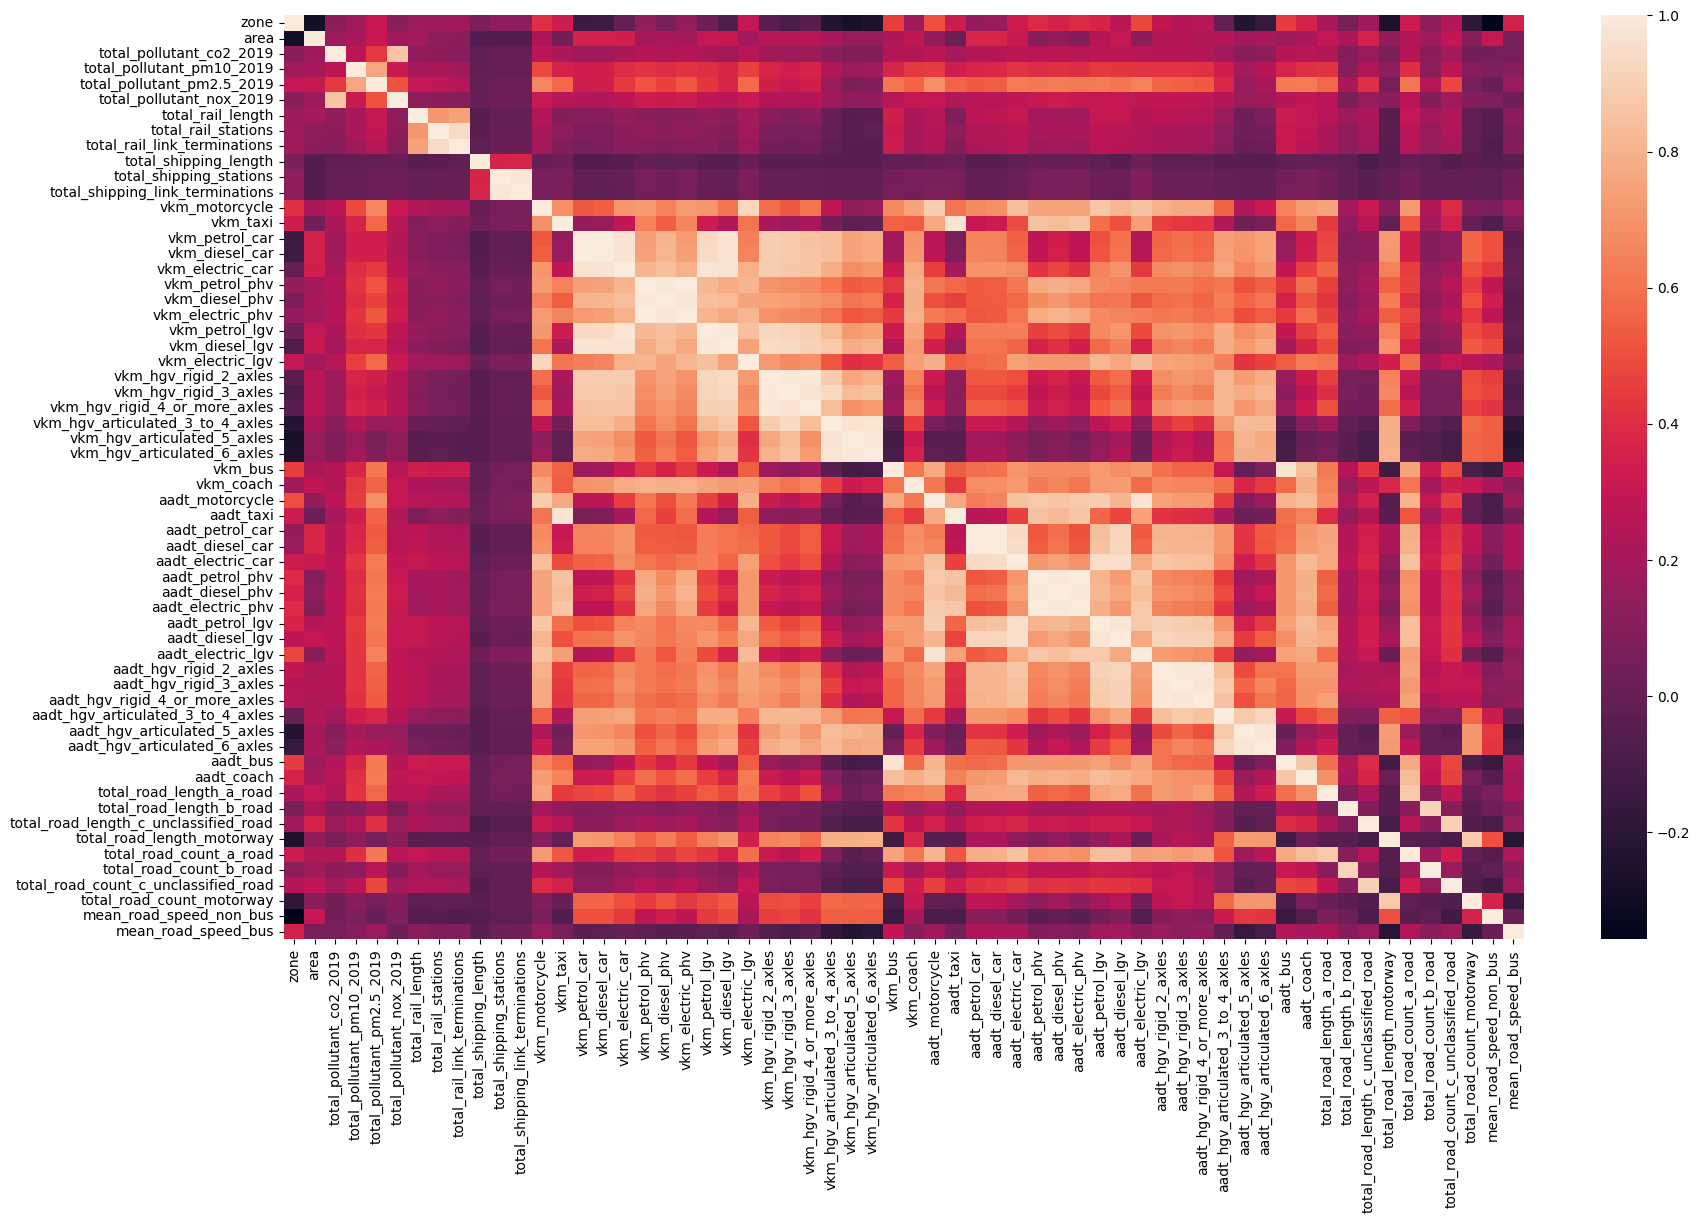

In [96]:
plt.figure(figsize=(20,12))
sns.heatmap(data[numerical_cols].corr())
plt.show()

There are clear blocks of high correlation, especially among variables related to vehicle kilometers traveled (vkm) and average annual daily traffic (aadt) metrics.
- vkm for petrol and diesel cars show a strong correlation, which makes sense since both contribute to overall road usage.
- aadt for different heavy goods vehicle (HGV) types also show strong internal correlations, reflecting similar usage patterns across vehicle classes.

**Pollutant Correlations:**
- The total pollutant levels (NOx, PM10, PM2.5) in 2019 show some correlation with traffic-related features like vkm for diesel cars and HGVs showing that road transport emissions significantly impact air quality.
- The correlation with electric vehicle kilometers (vkm electric) seems lower, as expected.

**Weak Correlations:**
- Some features (e.g: mean road speed for non-bus vehicles) show weak or even negative correlations with pollutant levels and traffic density, could be due to higher speeds occurring in less congested areas.

**Distinct Clusters:**
The heatmap visually reveals following imp clusters:
- `Traffic activity cluster`: vkm and aadt for various vehicles.
- `Pollutant cluster`: NOx, PM10, and PM2.5 interrelated but separate from traffic activity.
- `Road infrastructure cluster`: road length, road count, etc.

### Relationships between pollutant levels and key traffic metrics

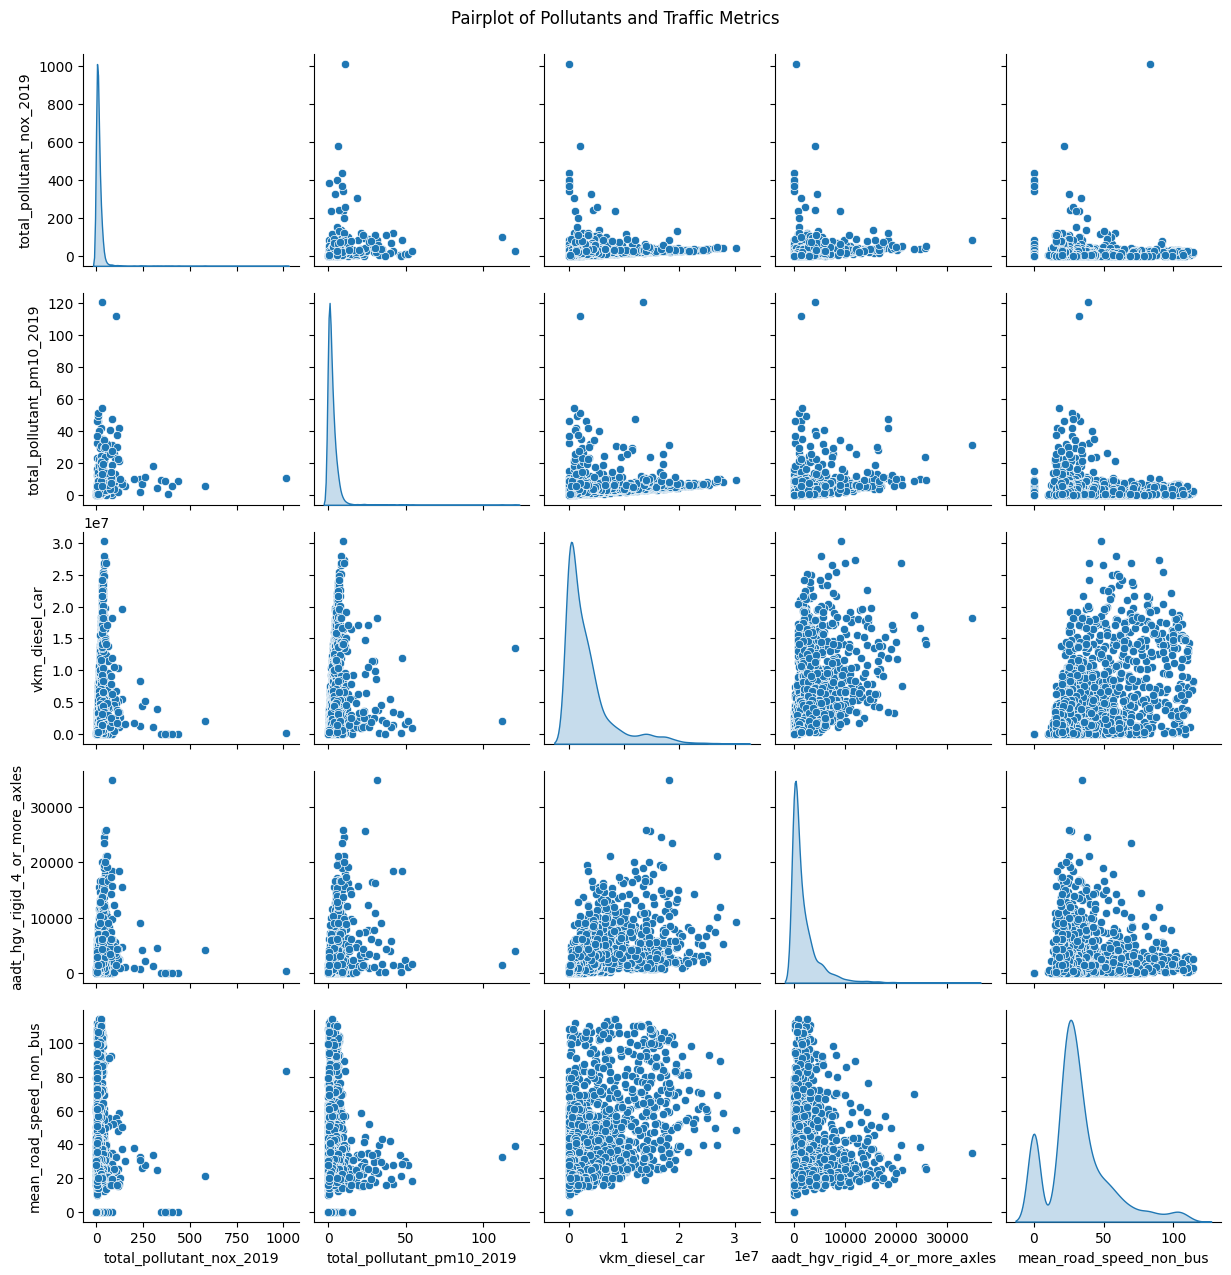

In [98]:
feats = [
    'total_pollutant_nox_2019', 
    'total_pollutant_pm10_2019',
    'vkm_diesel_car', 
    'aadt_hgv_rigid_4_or_more_axles', 
    'mean_road_speed_non_bus'
]

sns.pairplot(data[feats], diag_kind='kde')
plt.suptitle('Pairplot of Pollutants and Traffic Metrics', y=1.02)
plt.show()

1. Strong positive correlation is visible between NOx emissions and diesel car vehicle kilometers, demostrating the expected link between diesel traffic and nitrogen oxide levels.
2. Weak correlation between PM10 emissions and mean road speed, suggesting PM10 levels may be influenced more by other factors like vehicle type rather than speed.
3. Heavy goods vehicles show some moderate correlation with both pollutants, showing their contribution to overall emissions.
4. The right-skewed distributions for pollutants and traffic metrics indicate certain zones have extremely high emissions or traffic counts, possibly due to industrial areas or major roads.

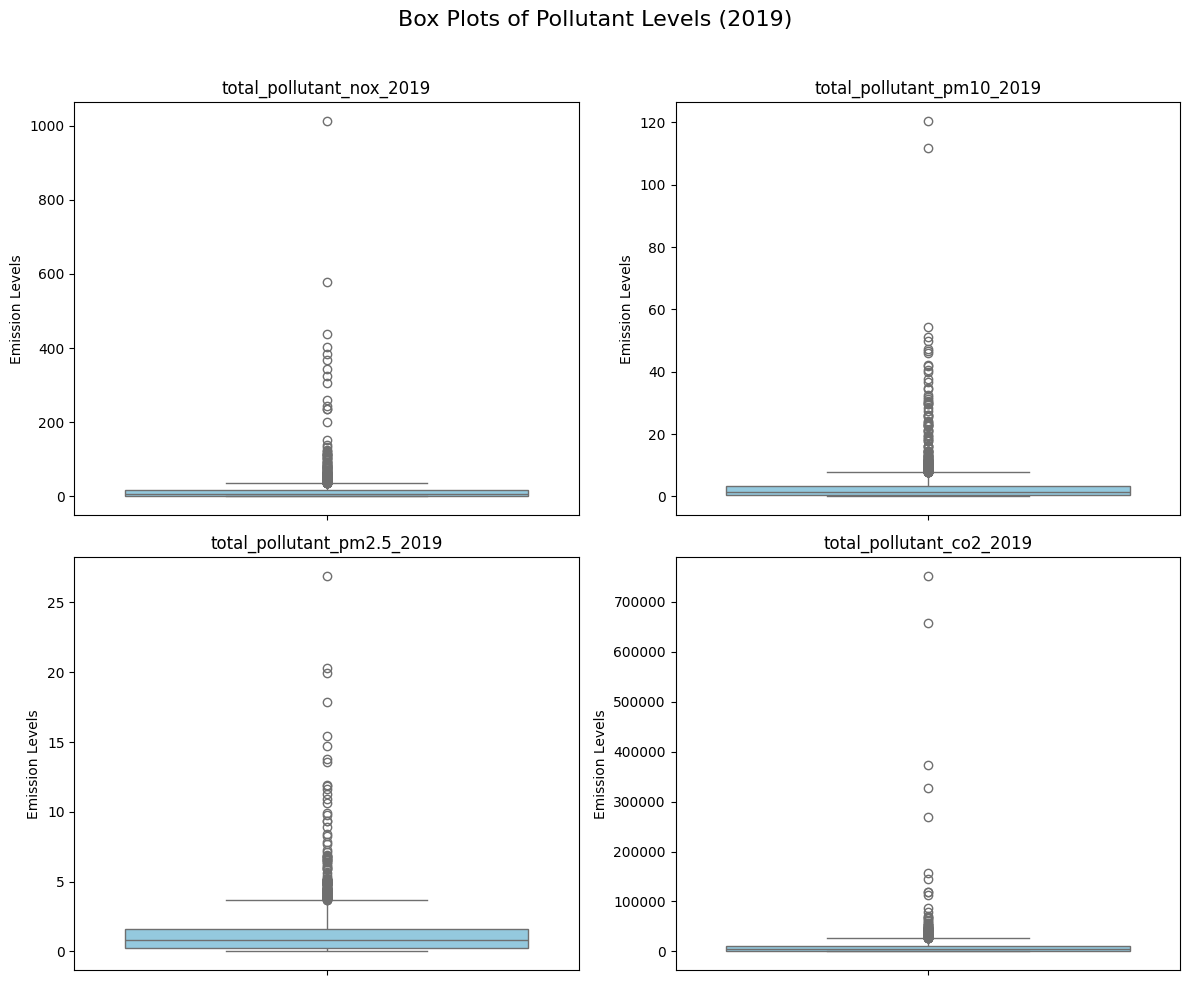

In [104]:
# Final check

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Box Plots of Pollutant Levels (2019)', fontsize=16)

axes = axes.flatten()

for i, col in enumerate(pollutants):
    sns.boxplot(y=data[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_ylabel('Emission Levels')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Predictive Modeling

We aim to develop models capable of predicting atmospheric pollutant levels. Given the nature of the task: **multi-output regression**, the following three machine learning algorithms cn be employed:

### Random Forest Regressor (with MultiOutputRegressor):

- **Why**: Random forests handle non-linearity well and are robust to overfitting due to their ensemble nature. By using the MultiOutputRegressor wrapper, we can extend this method to predict multiple pollutant levels (such as CO2, NOx, PM10, etc.) simultaneously.

- **Use case**: This model will help us capture complex interactions between categorical (borough, sector, etc.) and continuous features (year, pollutant levels) without extensive preprocessing.

### Gradient Boosting Regressor (XGBoost/LightGBM with MultiOutputRegressor):

- **Why**: Gradient boosting methods excel at learning from imbalanced data and capturing intricate patterns through iterative learning. They offer superior accuracy compared to simpler models.

- **Use case**: Particularly useful for identifying subtle factors driving pollutant emissions by weighting features dynamically, such as the impact of a particular sector or source.

### Linear Regression:

- **Why**: Linear models provide interpretable results, allowing us to clearly see the contribution of each feature to the predicted emission levels.

- **Use case**: This baseline model will serve as a benchmark to gauge the performance of more complex models.

In [4]:
# Load data
df = pd.read_pickle("processed_data/final_df.pkl")

In [5]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 95 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   grid_id                                3460 non-null   int32  
 1   zone                                   3460 non-null   int64  
 2   area                                   3460 non-null   float64
 3   total_pollutant_co2_2019               3460 non-null   float64
 4   total_pollutant_pm10_2019              3460 non-null   float64
 5   total_pollutant_pm2.5_2019             3460 non-null   float64
 6   total_pollutant_nox_2019               3460 non-null   float64
 7   total_rail_length                      3460 non-null   float64
 8   total_rail_stations                    3460 non-null   float64
 9   total_rail_link_terminations           3460 non-null   float64
 10  total_shipping_length                  3460 non-null   float64
 

In [5]:
#irrelevant features
df.drop(columns="grid_id", inplace=True)

In [6]:
#independent and dependent variables
pollutants = [
    "total_pollutant_pm10_2019", 
    "total_pollutant_pm2.5_2019", 
    "total_pollutant_co2_2019", 
    "total_pollutant_nox_2019"
]

independent_variables = [col for col in df.columns if col not in pollutants]

In [7]:
# outliers removal
df = remove_outliers_by_iqr(df, pollutants)

Dropping 117 (3.50%) as outliers.


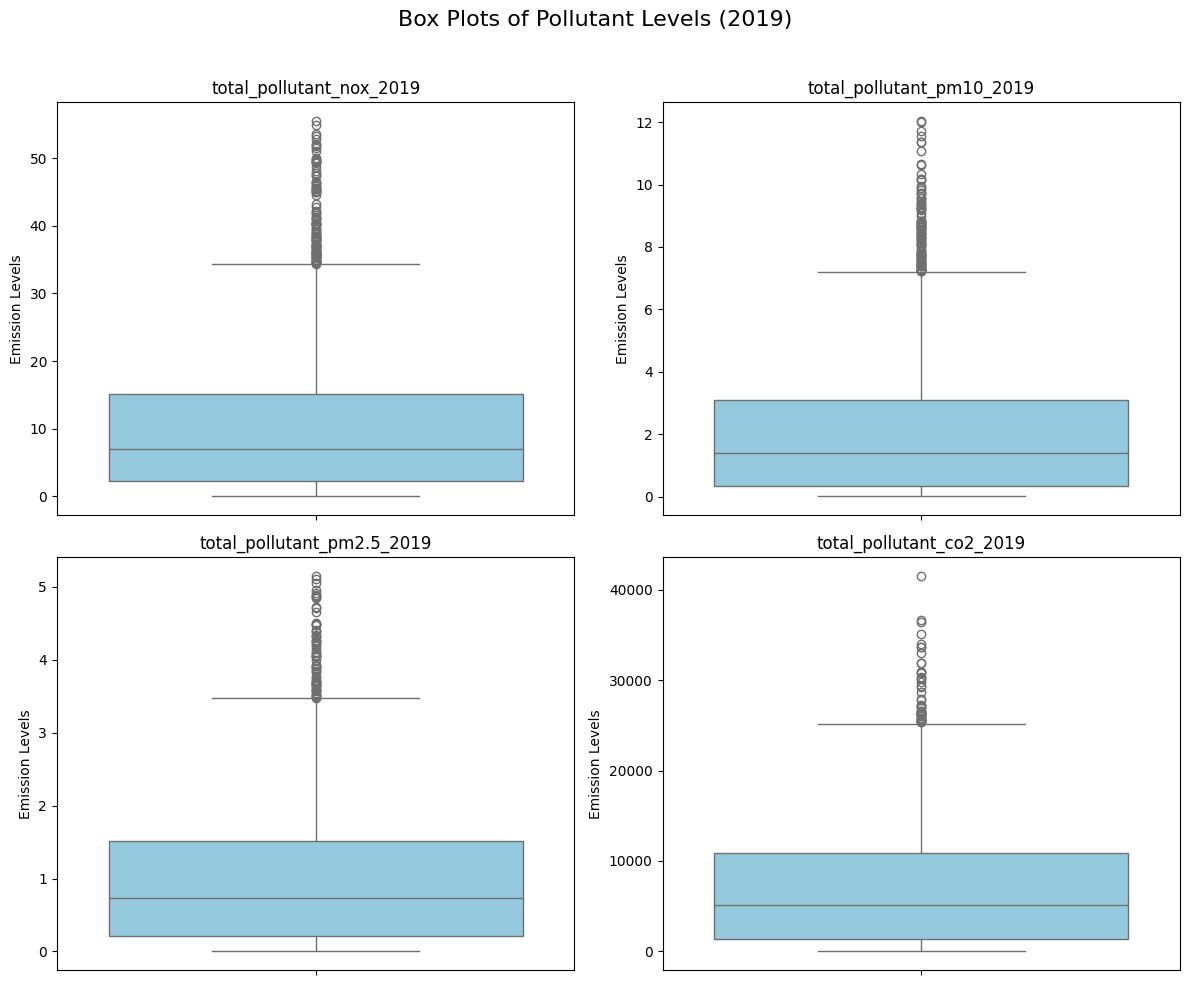

In [103]:
# Final check

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Box Plots of Pollutant Levels (2019)', fontsize=16)

axes = axes.flatten()

for i, col in enumerate(pollutants):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_ylabel('Emission Levels')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The box plots show the distribution of pollutant levels after removing 117 outliers (3.50%) using the IQR method. 

The distributions for **NOx, PM10, PM2.5, and CO2** are now more compact, with fewer extreme points. CO2 still shows a broader range compared to others, highlighting its variability even after outlier removal.

In [8]:
# train-test split for modeling

X = df[independent_variables] # features
y = df[pollutants] # taregt


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Feature scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [10]:
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

## Linear Regression Model

In [11]:
base_model = LinearRegression()
multioutput_model = MultiOutputRegressor(base_model)

In [12]:
multioutput_model.fit(X_train_scaled, y_train_scaled)

MultiOutputRegressor(estimator=LinearRegression())

In [13]:
#predictions
y_pred_scaled = multioutput_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_test_actual = scaler_y.inverse_transform(y_test_scaled)

In [18]:
mae = mean_absolute_error(y_test_actual.flatten(), y_pred.flatten())
mse = mean_squared_error(y_test_actual.flatten(), y_pred.flatten())
r2 = r2_score(y_test_actual.flatten(), y_pred.flatten())


print(f"MAE: {mae:.2f} \nMSE: {mse:.2f} \nR2: {r2:.2f}")

MAE: 401.98 
MSE: 1294827.77 
R2: 0.93


total_pollutant_pm10_2019 - MAE: 0.63, MSE: 1.15, R2: 0.76


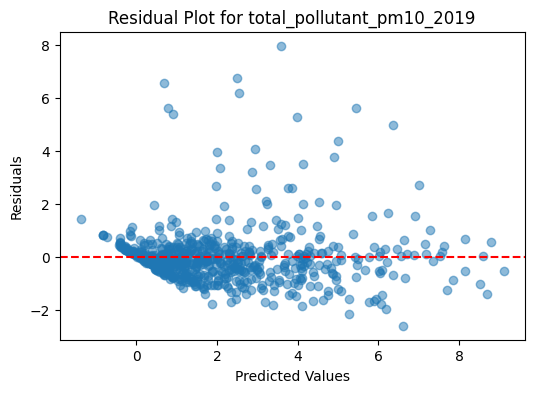

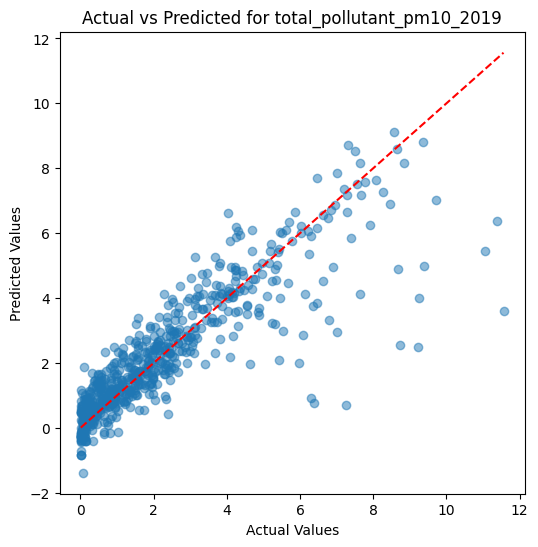

total_pollutant_pm2.5_2019 - MAE: 0.28, MSE: 0.16, R2: 0.82


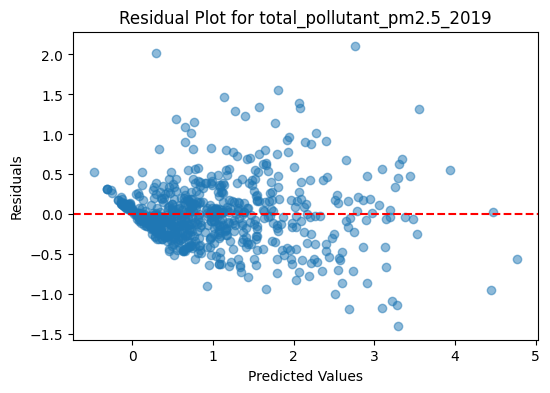

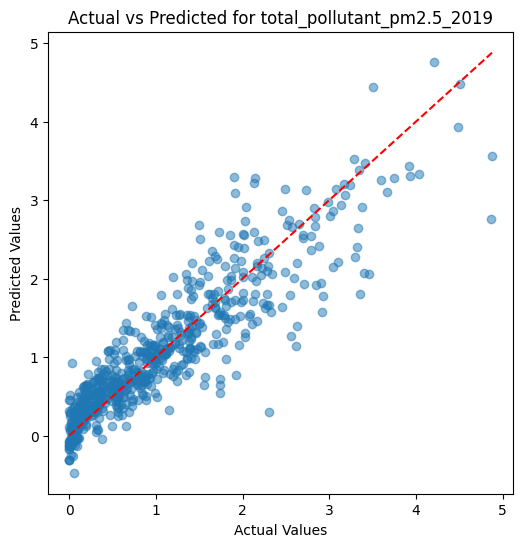

total_pollutant_co2_2019 - MAE: 1604.90, MSE: 5179294.31, R2: 0.88


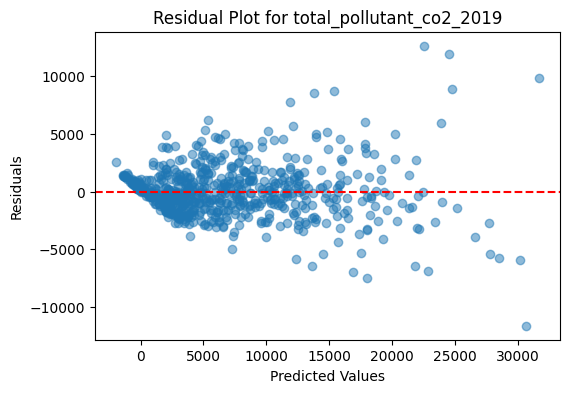

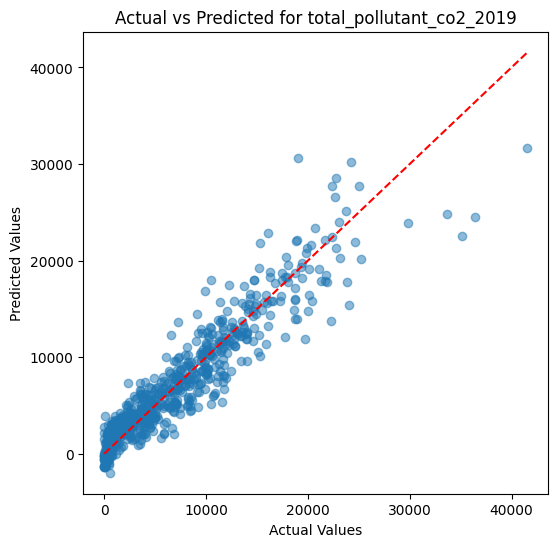

total_pollutant_nox_2019 - MAE: 2.10, MSE: 15.45, R2: 0.85


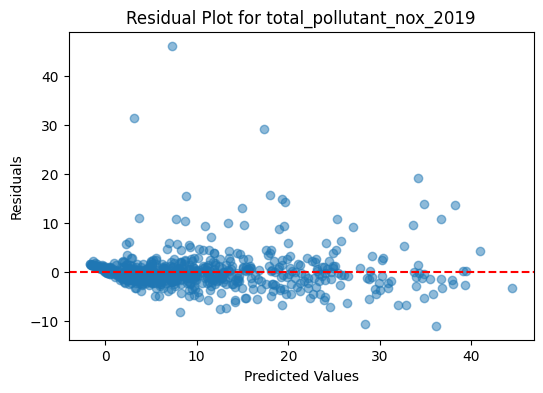

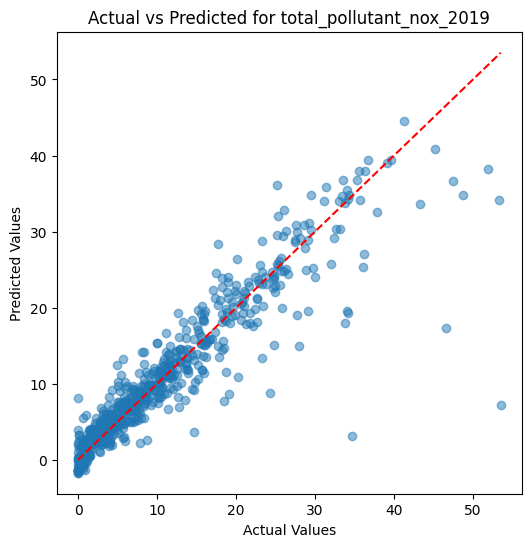

In [14]:
# Evaluate model - indivdual analysis
for i, pollutant in enumerate(pollutants):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    mse = mean_squared_error(y_test_actual[:, i], y_pred[:, i])
    r2 = r2_score(y_test_actual[:, i], y_pred[:, i])
    print(f"{pollutant} - MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")

    #residual analysis plot
    residuals = y_test_actual[:, i] - y_pred[:, i]
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred[:, i], residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {pollutant}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    #actual vs predicted 
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_actual[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test_actual[:, i].min(), y_test_actual[:, i].max()], 
             [y_test_actual[:, i].min(), y_test_actual[:, i].max()], 
             color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for {pollutant}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

## Random Forest Regression 

In [33]:
# we will use unscaled data version as Random forest doesnot require scaling.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Random-Forest regressor object
rf = RandomForestRegressor(random_state=42)

#grid-seacrh for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', verbose=1)

In [35]:
# multioutput wrapper
multioutput_rf = MultiOutputRegressor(grid_search)

In [36]:
multioutput_rf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


MultiOutputRegressor(estimator=GridSearchCV(cv=3,
                                            estimator=RandomForestRegressor(random_state=42),
                                            param_grid={'max_depth': [10, 20,
                                                                      30],
                                                        'min_samples_split': [2,
                                                                              5,
                                                                              10],
                                                        'n_estimators': [50,
                                                                         100,
                                                                         150]},
                                            scoring='r2', verbose=1))

In [67]:
# extracting the best estimators for each target(pollutant)
best_estimators = [
    multioutput_rf.estimators_[0].best_estimator_,
    multioutput_rf.estimators_[1].best_estimator_,
    multioutput_rf.estimators_[2].best_estimator_,
    multioutput_rf.estimators_[3].best_estimator_,
]

best_estimators

[RandomForestRegressor(max_depth=20, random_state=42),
 RandomForestRegressor(max_depth=20, min_samples_split=5, random_state=42),
 RandomForestRegressor(max_depth=20, n_estimators=150, random_state=42),
 RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=50,
                       random_state=42)]

In [68]:
for i, estimator in enumerate(best_estimators):
    estimator.fit(X_train, y_train.iloc[:, i])

In [69]:
# Predicting for each target pollutant

y_pred = np.column_stack([estimator.predict(X_test) for estimator in best_estimators])

In [72]:
mae = mean_absolute_error(y_test.values.flatten(), y_pred.flatten())
mse = mean_squared_error(y_test.values.flatten(), y_pred.flatten())
r2 = r2_score(y_test.values.flatten(), y_pred.flatten())


print(f"MAE: {mae:.2f} \nMSE: {mse:.2f} \nR2: {r2:.2f}")

MAE: 364.67 
MSE: 1281429.90 
R2: 0.94


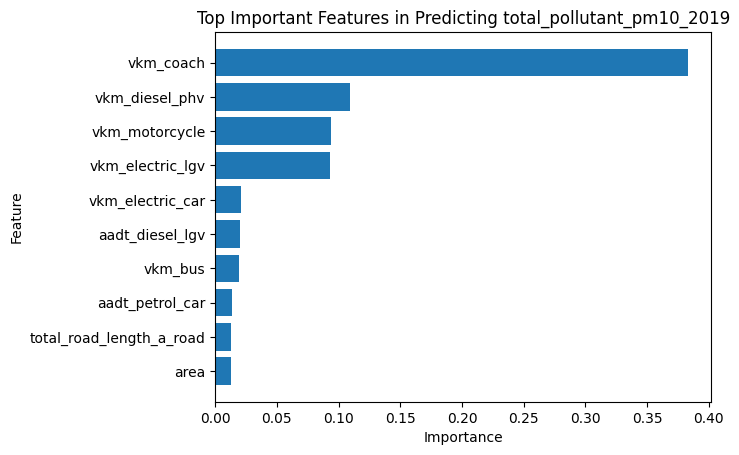

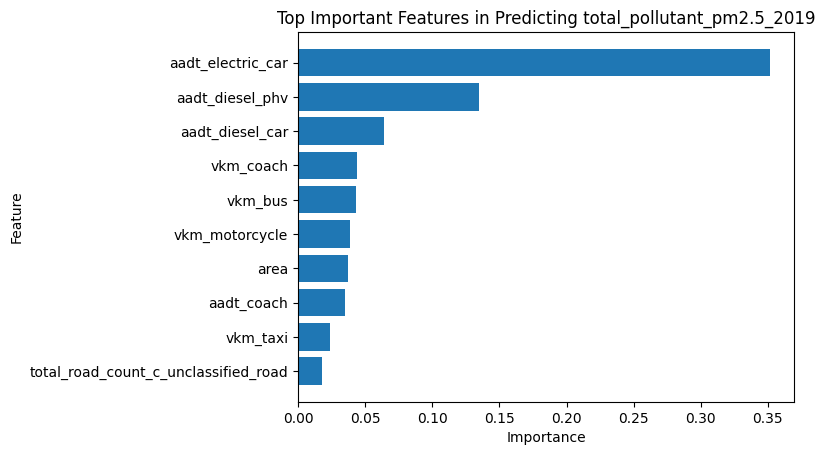

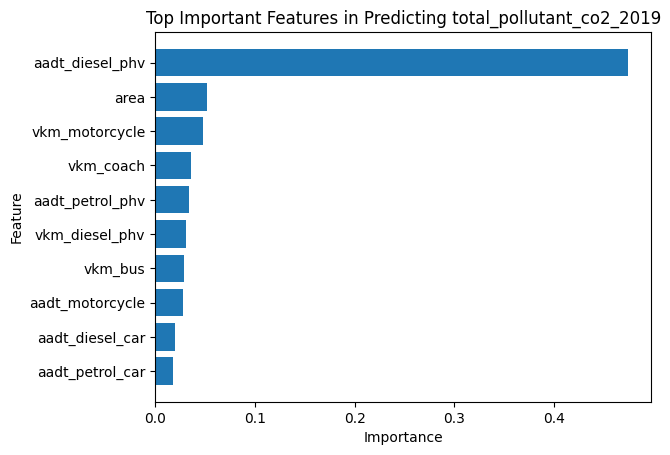

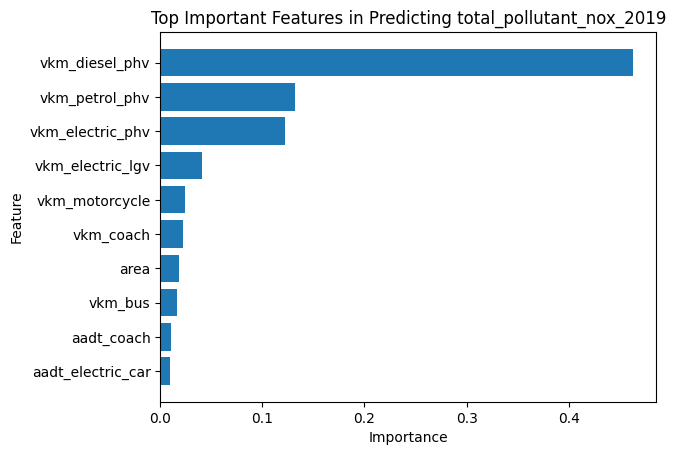

In [76]:
# feature importances for each output variable
for i, estimator in enumerate(best_estimators):
    feature_importances = estimator.feature_importances_
    importance_df = pd.DataFrame({'feature': X.columns, 'importance score': feature_importances})
    importance_df = importance_df.sort_values(by='importance score', ascending=False).head(10)
    
    pollutant = y.columns[i]
    
    plt.barh(importance_df['feature'], importance_df['importance score'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top Important Features in Predicting {pollutant}')
    plt.gca().invert_yaxis()
    plt.show()

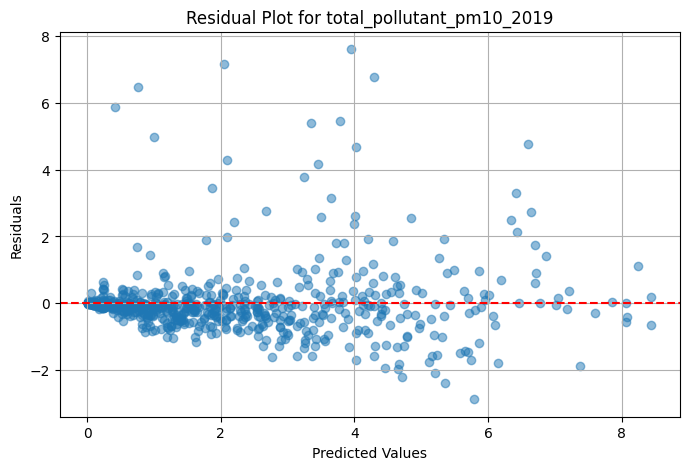

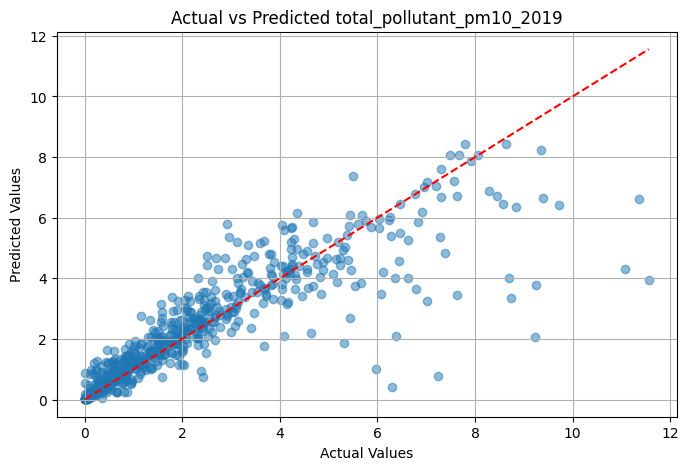

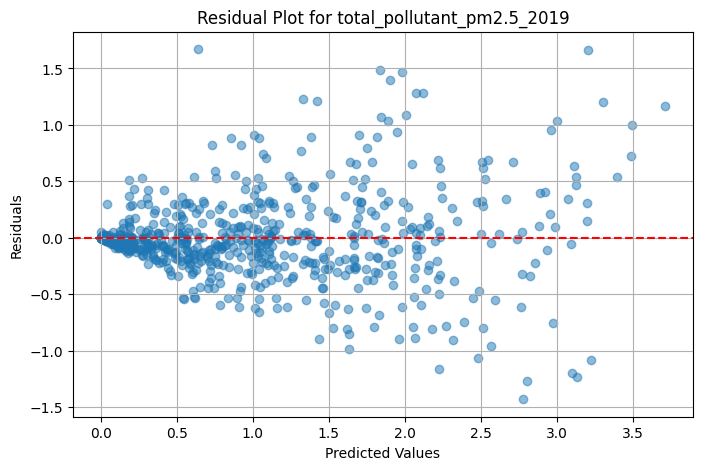

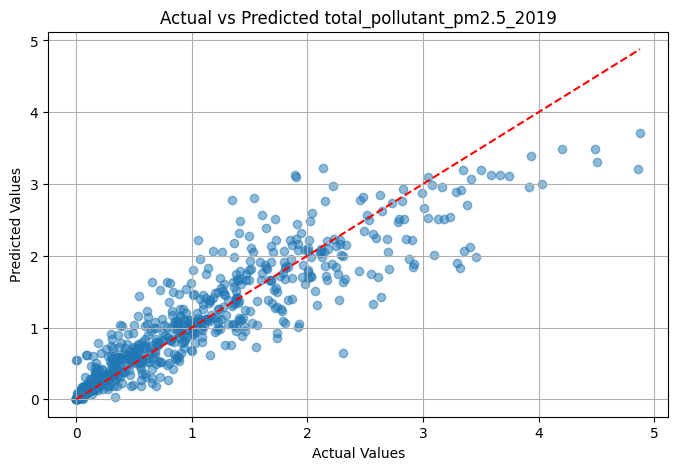

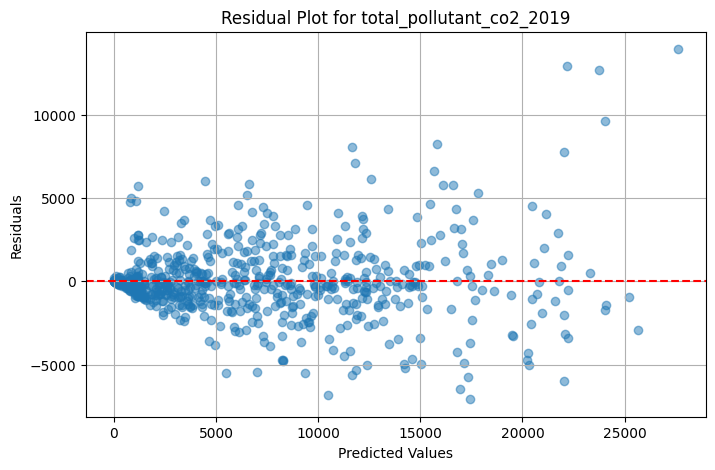

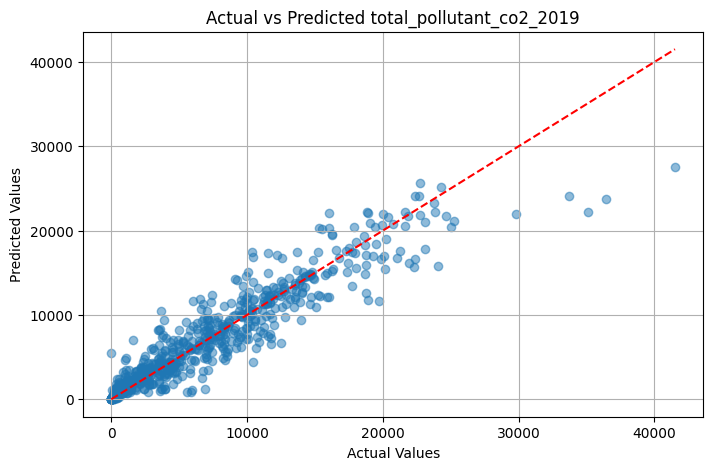

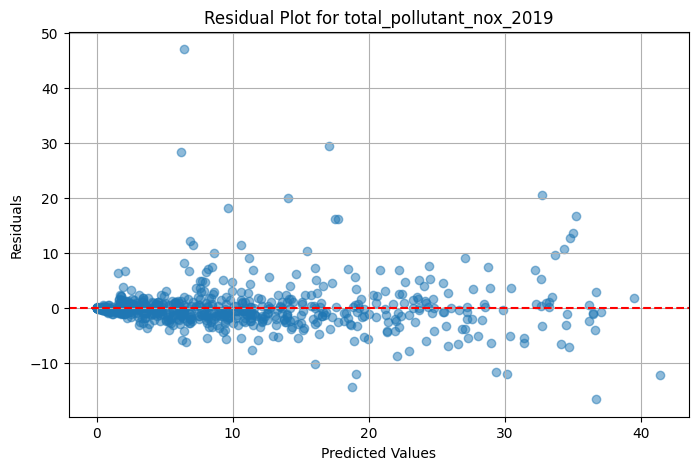

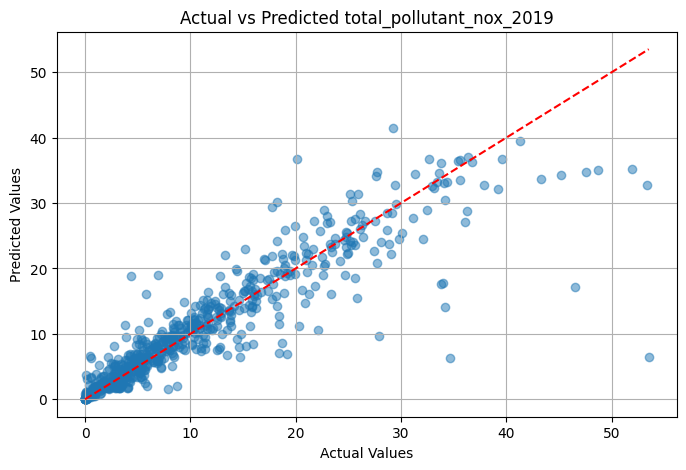

In [77]:
# model evalutaion
for i, pollutant in enumerate(pollutants):
    # residuals
    plt.figure(figsize=(8, 5))
    residuals = y_test.iloc[:, i] - y_pred[:, i]
    plt.scatter(y_pred[:, i], residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {pollutant}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # actual vs predicted
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
             [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {pollutant}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

## XGBoost Regressor 

In [78]:
# since xgboost uses decision trees as base learners, and decision trees are not sensitive to 
# feature magnitudes so we will use unscaled data here as well.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# xgboost Regressor
xgb = XGBRegressor(random_state=101)

# grid-seacrh for hyperparameter tuning
param_grid = {
        'max_iter': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'min_samples_leaf': [20, 30]
}

grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv=3, scoring='r2', 
                           verbose=1)

In [85]:
# multioutput wrapper
multioutput_xgb = MultiOutputRegressor(grid_search_xgb)

In [86]:
multioutput_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits


MultiOutputRegressor(estimator=GridSearchCV(cv=3,
                                            estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=101, ...),
                                            param_grid={'learning_rate': [0.05,
                                                                          0.1],
                                                        'max_depth': [3, 5],
                                                        'max_iter': [100, 200],
                                                        'min_samples_leaf': [20,
                                                                             30]},
                                            scoring='r2', verbose=1))

In [87]:
# best estimators for each target variable
best_estimators = [
    multioutput_xgb.estimators_[0].best_estimator_,
    multioutput_xgb.estimators_[1].best_estimator_,
    multioutput_xgb.estimators_[2].best_estimator_,
    multioutput_xgb.estimators_[3].best_estimator_,
]

best_estimators

[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_iter=100, max_leaves=None,
              min_child_weight=None, min_samples_leaf=20, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=N

In [88]:
for i, estimator in enumerate(best_estimators):
    estimator.fit(X_train, y_train.iloc[:, i])

In [89]:
#predictins on testset
y_pred = np.column_stack([estimator.predict(X_test) for estimator in best_estimators])

In [90]:
# evaluation metrics

mae = mean_absolute_error(y_test.values.flatten(), y_pred.flatten())
mse = mean_squared_error(y_test.values.flatten(), y_pred.flatten())
r2 = r2_score(y_test.values.flatten(), y_pred.flatten())


print(f"MAE: {mae:.2f} \nMSE: {mse:.2f} \nR2: {r2:.2f}")

MAE: 365.89 
MSE: 1176346.66 
R2: 0.94


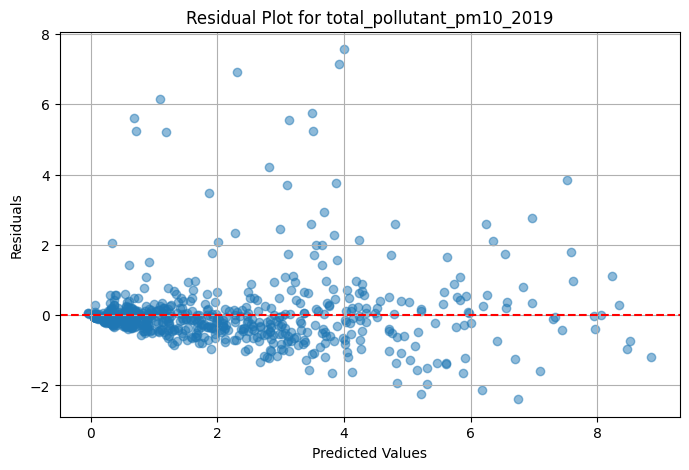

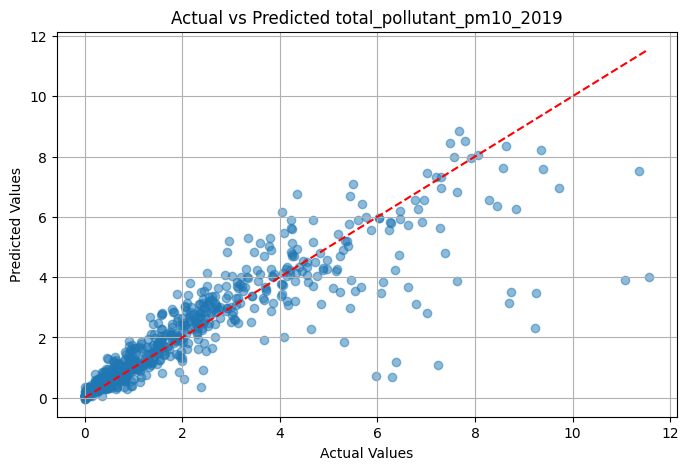

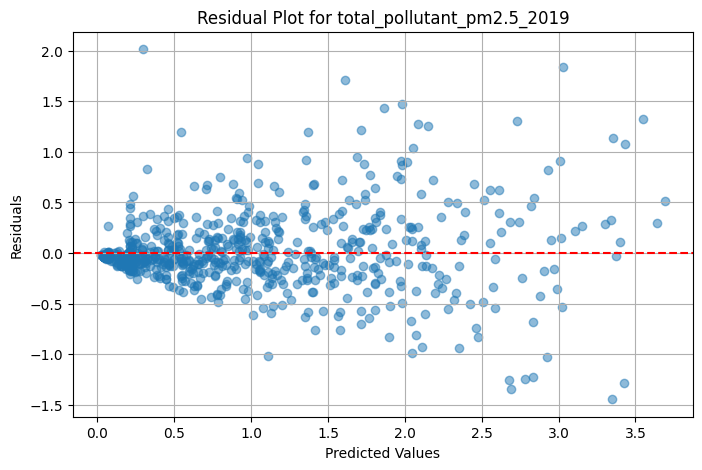

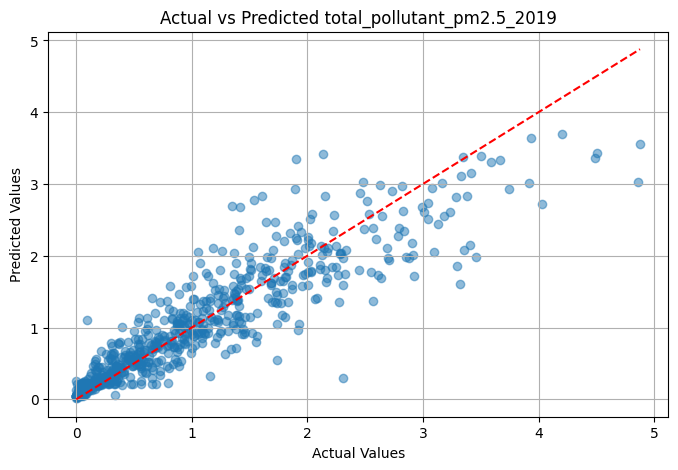

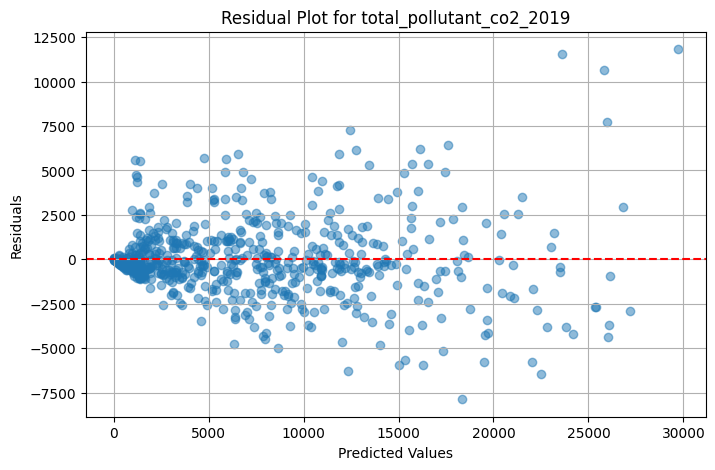

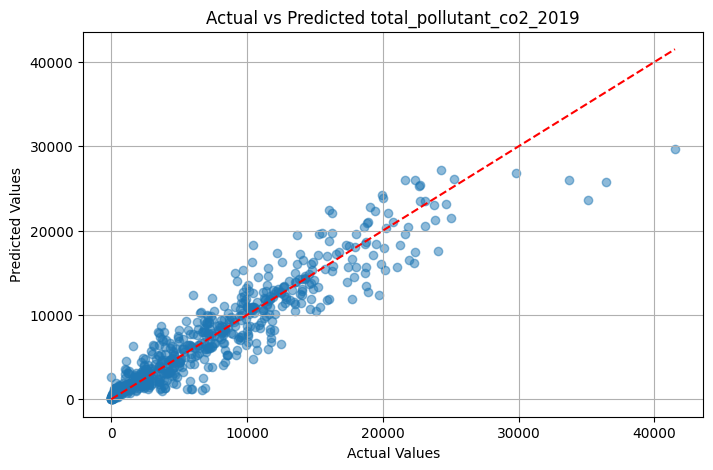

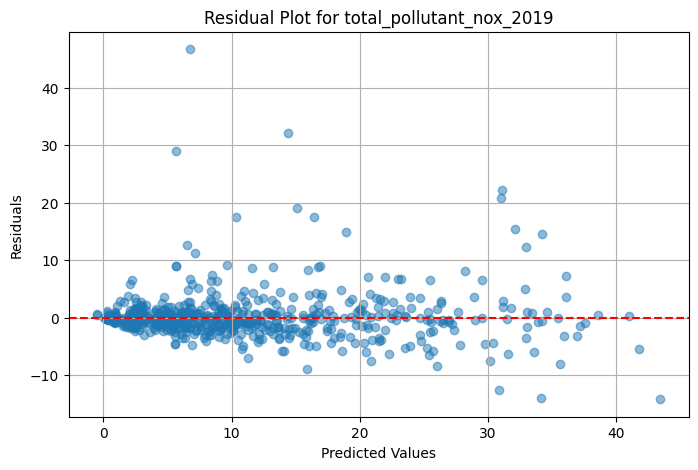

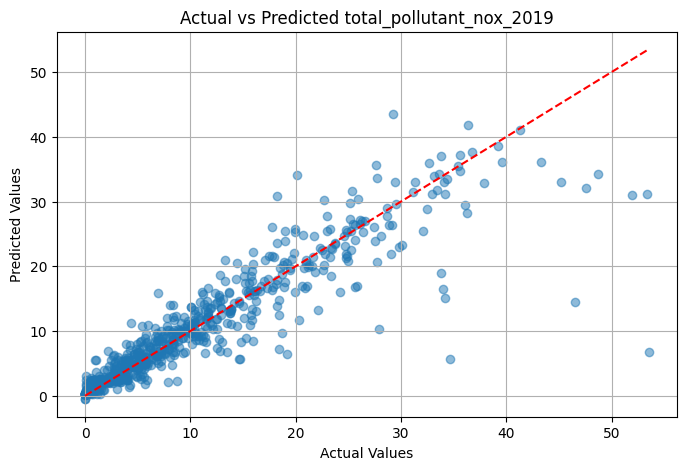

In [91]:
# training evalutaion
for i, pollutant in enumerate(pollutants):
    # residuals
    plt.figure(figsize=(8, 5))
    residuals = y_test.iloc[:, i] - y_pred[:, i]
    plt.scatter(y_pred[:, i], residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {pollutant}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # actual vs predicted
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 
             [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], color='red', linestyle='--')
    plt.title(f'Actual vs Predicted {pollutant}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()